/home/dronelab/delaunay_rasterization


/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


torch.Size([1, 3]) torch.Size([80000, 3])
1.9999982


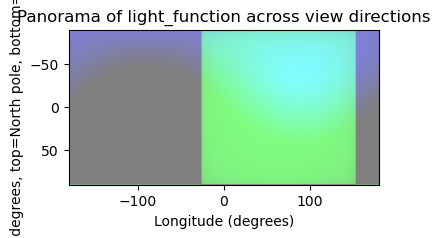

In [1]:
import torch
import plotly.graph_objects as go
import math

import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))

from models.ingp_color import *
import matplotlib.pyplot as plt

"""
Creates a 2D latitude-longitude grid of directions (view_dirs),
evaluates light_function, and displays the result as a panorama.
"""

# Fix constants
base_color      = torch.tensor([[1.0, 1.0, 1.0]])   # White base color
reflection_dirs = l2_normalize_th(torch.tensor([[[1.0, 2.0, 0.0], [0.0, 1.0, 1.0]]]))
light_colors    = torch.tensor([[[0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]])   # White light
light_roughness = torch.tensor([[[0.05], [1.3]]])            # Arbitrary roughness

# Panorama resolution
#   width ~ number of longitudes (phi), height ~ number of latitudes (theta)
width  = 400
height = 200

# Spherical coordinates:
#   phi   in [-π, π], covering a full 360° horizontally
#   theta in [0, π], from north pole (theta=0) to south pole (theta=π)
# We can also do [-π/2, π/2], but equirectangular usually does full sphere in theta.
phi_vals   = torch.linspace(-np.pi, np.pi, width)
theta_vals = torch.linspace(0, np.pi, height)

# We'll build a grid of directions, shape = (width * height, 3).
# Spherical-to-Cartesian:
#   x = sin(theta)*cos(phi)
#   y = sin(theta)*sin(phi)
#   z = cos(theta)
all_dirs = []
for t in theta_vals:
    for p in phi_vals:
        x = torch.sin(t) * torch.cos(p)
        y = torch.sin(t) * torch.sin(p)
        z = torch.cos(t)
        all_dirs.append([x, y, z])
view_dirs = torch.tensor(all_dirs, dtype=torch.float32)

# Evaluate the function for all directions (dim = width*height)
print(base_color.shape, view_dirs.shape)
results = light_function(base_color, 
                            reflection_dirs, 
                            light_colors, 
                            light_roughness, 
                            view_dirs.reshape(-1, 1, 3))

# Reshape result to 2D image for display. 
# 'results' is shape (width*height, 3). We want shape (height, width, 3)
results_2d = results.reshape(height, width, 3).numpy()

print(results_2d.max())
results_2d = results_2d / results_2d.max()

# Plot using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(results_2d, origin='upper', extent=(-180, 180, 90, -90))
plt.title('Panorama of light_function across view directions')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees, top=North pole, bottom=South pole)')
plt.axis('on')
plt.show()